In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy
from scipy.stats import linregress

from acspype import ACSDev, ACSTSCor
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc

## Import Data

In [2]:
acs = xr.open_dataset('../dev_tools/test_files/PROMETHEUS_AGG_SHIMADA_202405.nc', group = 'acs')
acs = acs.drop_vars(['packet_type','record_length', 'packet',  # Drop variables that are not used or will get recomputed.
                     'internal_temperature', 'external_temperature',
                     'a_uncorr','c_uncorr','a_pg',
                     'c_pg','raw_external_temperature'], errors = 'ignore')

tsg = xr.open_dataset('../dev_tools/test_files/PROMETHEUS_AGG_SHIMADA_202405.nc', group = 'tsg')
tsg = tsg.drop_vars(['sea_water_electrical_conductivity'], errors = 'ignore')
tsg = tsg.where(tsg['sea_water_temperature'] > 0, drop=True) 
tsg = tsg.where(tsg['sea_water_temperature'] < 35, drop=True)
tsg = tsg.where(tsg['sea_water_practical_salinity'] > 22, drop=True) 
tsg = tsg.where(tsg['sea_water_temperature'] < 35, drop=True) 
tsg = tsg.rolling({'time': 11}, center = True).median(skipna = True)
tsg = tsg.interp(time=acs.time, method='nearest', kwargs={'fill_value': 'extrapolate'})

valve = xr.open_dataset('../dev_tools/test_files/PROMETHEUS_AGG_SHIMADA_202405.nc', group = 'valve')
valve = valve.drop_vars(['valve_relay_state'], errors = 'ignore')
valve = valve.interp(time = acs.time, method='nearest', kwargs={'fill_value': 'extrapolate'})

gps = xr.open_dataset('../dev_tools/test_files/PROMETHEUS_AGG_SHIMADA_202405.nc', group = 'gps')
gps = gps.drop_vars(['GPGGA'], errors = 'ignore')
gps = gps.interp(time = acs.time, method='nearest', kwargs={'fill_value': 'extrapolate'})


acs = xr.combine_by_coords([acs,tsg, valve, gps])

dev = ACSDev('../dev_tools/test_files/ACS-00412_2023-05-10.dev')

## Reprocess Data

In [3]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(acs.raw_internal_temperature)

In [4]:
acs['a_uncorrected'] = acsproc.compute_uncorrected(acs.a_signal, acs.a_reference, dev.path_length)
acs['c_uncorrected'] = acsproc.compute_uncorrected(acs.c_signal, acs.c_reference, dev.path_length)

In [5]:
acs['a_pg_discontinuity' ] = acsproc.compute_measured(acs.a_uncorrected, acs.internal_temperature, dev.a_offset, dev.func_a_delta_t)
acs['c_pg_discontinuity' ] = acsproc.compute_measured(acs.c_uncorrected, acs.internal_temperature, dev.c_offset, dev.func_c_delta_t)

In [6]:
%%time
discontinuity_index = acsproc.find_discontinuity_index(acs.a_wavelength, acs.c_wavelength)
acs['a_pg'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(acs.a_pg_discontinuity, discontinuity_index, 'a_wavelength')
acs['c_pg'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(acs.c_pg_discontinuity, discontinuity_index, 'c_wavelength')

CPU times: total: 10min 5s
Wall time: 10min 7s


In [7]:
tscor = ACSTSCor().to_xarray()

psi_s_a = tscor.psi_s_a.sel(wavelength = acs.a_wavelength)
psi_s_c = tscor.psi_s_c.sel(wavelength = acs.c_wavelength)
psi_t_a = tscor.psi_t.sel(wavelength = acs.a_wavelength)
psi_t_c = tscor.psi_t.sel(wavelength = acs.c_wavelength)

acs['a_pgts'] = acsproc.ts_correction(acs.a_pg, acs.sea_water_temperature, acs.sea_water_practical_salinity, psi_t_a, psi_s_a, dev.tcal)
acs['c_pgts'] = acsproc.ts_correction(acs.c_pg, acs.sea_water_temperature, acs.sea_water_practical_salinity, psi_t_c, psi_s_c, dev.tcal)

In [11]:
off = acs.a_discontinuity_offset

In [14]:
off.quantile([0.01, 0.99], dim = 'time')

<xarray.DataArray 'a_discontinuity_offset' (quantile: 2)> Size: 16B
array([-0.00845,  0.00246])
Coordinates:
  * quantile  (quantile) float64 16B 0.01 0.99

In [13]:
off.max()

<xarray.DataArray 'a_discontinuity_offset' ()> Size: 8B
array(16.48314)

In [8]:
test = acs['a_pgts'].sel(a_wavelength = 725, method = 'nearest')
test = test.where((test > 0) & (test < 0.1), drop=True)

In [9]:
slope, intercept, r, p, se = linregress(test.time.astype(int), test)

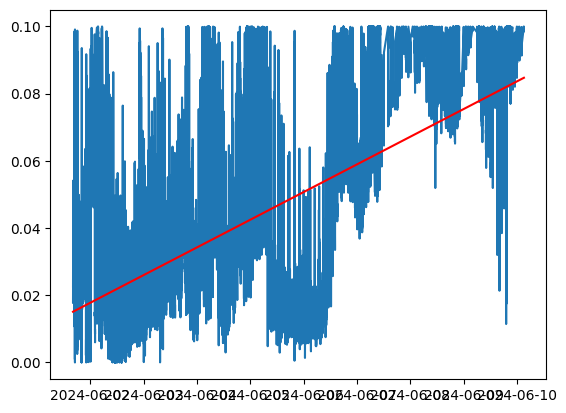

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(test.time, test)
ax.plot(test.time, intercept + slope * test.time.astype(int),'r')